In [1]:
import json
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder
from gnn import ExpValCircuitGraphModel
plt.style.use({'figure.facecolor':'white'})

In [2]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

# Training

In [5]:
train_paths = [
    f'./data/haoran_mbd/random_brickwork/depth{i}.json' for i in range(10)
]

val_paths = [
     f'./data/mbd_datasets2/theta_0.05pi/val/step_{i}.json' for i in range(10)
]

In [9]:
BATCH_SIZE = 1

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[1213, 22], edge_index=[2, 2721], edge_attr=[1508, 3], y=[32, 1, 4], observable=[32, 0], circuit_depth=[32, 1], noisy_0=[32, 1, 4], batch=[1213], ptr=[33])


In [12]:
for i, data in enumerate(val_loader):
    if i == 100:
        tmp_data = data

In [13]:
tmp_data

13645
5024 2016


In [ ]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15
)
criterion = torch.nn.MSELoss()

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,
                              'min',
                              factor=0.1,
                              patience=15,
                              verbose=True,
                              min_lr=0.00001)

Model training:   0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(len(train_loader) * BATCH_SIZE, len(val_loader) * BATCH_SIZE)

13645
5024 2016


In [25]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 50

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch
        )
        loss = criterion(out, torch.squeeze(data.y, 1))

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch)
        loss = criterion(out, torch.squeeze(data.y, 1))

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 00047: reducing learning rate of group 0 to 1.0000e-04.


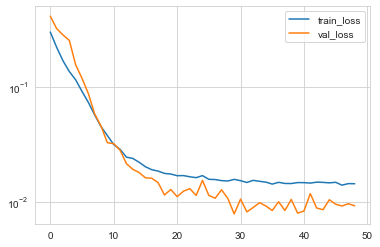

In [26]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

In [7]:
model_path = './model/haoran_mbd2/random_brickwork2.pth'

In [28]:
# torch.save(model.state_dict(), model_path)

In [29]:
# import pickle
#
# to_save = {'train_losses': train_losses, 'val_losses': val_losses}
# with open('.'+model_path.split('.')[1]+'.pk', 'wb') as handle:
#     pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test on charge imbalance on newly generated MBL circuits

In [17]:
model_path

'./model/haoran_mbd2/random_brickwork2.pth'

In [8]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15
)
model.load_state_dict(torch.load(model_path))
model.eval()

ExpValCircuitGraphModel(
  (transformer1): TransformerConv(22, 15, heads=3)
  (pooling1): ASAPooling(45, ratio=0.5)
  (transformer2): TransformerConv(45, 15, heads=2)
  (pooling2): ASAPooling(30, ratio=0.5)
  (body_seq): Sequential(
    (0): Linear(35, 15, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(15, 4, bias=True)
  )
)

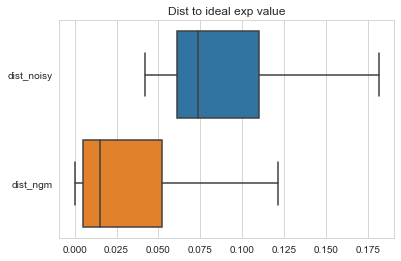

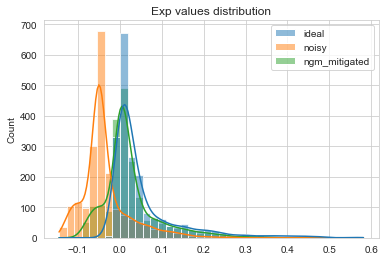

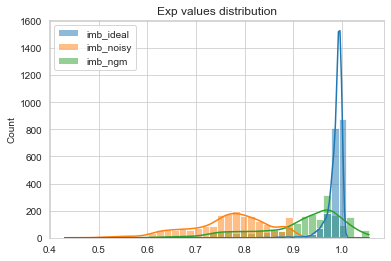

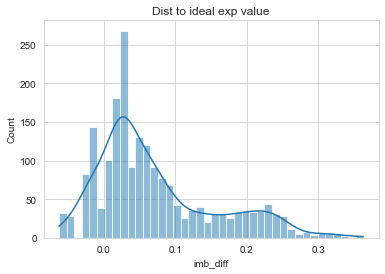

In [21]:
model.eval()
distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

for i, data in enumerate(val_loader):
    out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)

    for ideal, noisy, ngm_mitigated in zip(
        data.y.tolist(),
        data.noisy_0.tolist(),
        out.tolist()
    ):
        imbalance_ideal = calc_imbalance(ideal, even_qubits, odd_qubits)[0]
        imbalance_noisy = calc_imbalance(noisy, even_qubits, odd_qubits)[0]
        imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]

        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
            "imb_ideal": imbalance_ideal,
            "imb_noisy": imbalance_noisy,
            "imb_ngm": imbalance_mitigated,
            "imb_diff": imbalance_ideal - imbalance_mitigated
        })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

sns.histplot([df['imb_ideal'], df['imb_noisy'], df["imb_ngm"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

sns.histplot(data=df["imb_diff"], kde=True, bins=40)
plt.title("Dist to ideal exp value")
plt.show()

In [19]:
## Now we need to average over many disorders
num_disorders = 10

num_spins = 4 # Number of spins. Must be even.
W = 0.8 * np.pi # Disorder strength up to np.pi
theta = 0.05 * np.pi # Interaction strength up to np.pi
max_steps = 10

even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

# For each disorder realization, make a new disorder
# and compute the charge imbalance using the same physics parameters as before
imbalance_all_ideal = []
imbalance_all_noisy = []
imbalance_all_mitigated = []

for disorder_realization in tqdm(range(num_disorders)):
    disorders = generate_disorder(num_spins, W)
    # print(disorders)

    qc_list = []
    for steps in range(max_steps):
        qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

    transpiled_qc_list = transpile(qc_list, backend_noisy, optimization_level=3)
    job_ideal = execute(qc_list, **run_config_ideal)
    job_noisy = execute(transpiled_qc_list, **run_config_noisy)

    exp_Z_ideal = []
    exp_Z_noisy = []
    exp_Z_mitigated = []

    for i in range(len(qc_list)):
        counts_ideal = job_ideal.result().get_counts()[i]
        counts_noisy = job_noisy.result().get_counts()[i]

        ideal_exp_val = cal_z_exp(counts_ideal)
        noisy_exp_val = cal_z_exp(counts_noisy)

        exp_Z_ideal.append(list(ideal_exp_val)) # Single-Z expectation value of each qubit
        exp_Z_noisy.append(list(noisy_exp_val)) # Single-Z expectation value of each qubit

        graph_data = circuit_to_graph_data_json(
            circuit=transpiled_qc_list[i],
            properties=properties,
            use_qubit_features=True,
            use_gate_features=True,
        )

        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=ideal_exp_val.tolist(),
            noisy_exp_values=[noisy_exp_val.tolist()],
            circuit_depth=transpiled_qc_list[i].depth()
        ).to_pyg_data()

        # print(entry.batch)
        mitigated_exp_val = model(entry.noisy_0,
                            entry.observable,
                            entry.circuit_depth,
                            entry.x,
                            entry.edge_index,
                            entry.batch).tolist()[0]

        exp_Z_mitigated.append(mitigated_exp_val)

    imbalance_ideal = calc_imbalance(exp_Z_ideal, even_qubits, odd_qubits)
    imbalance_noisy = calc_imbalance(exp_Z_noisy, even_qubits, odd_qubits)
    imbalance_mitigated = calc_imbalance(exp_Z_mitigated, even_qubits, odd_qubits)

    imbalance_all_ideal.append(imbalance_ideal)
    imbalance_all_noisy.append(imbalance_noisy)
    imbalance_all_mitigated.append(imbalance_mitigated)

# Average imbalance
imbalance_ideal_average = np.mean(imbalance_all_ideal, axis=0)
imbalance_noisy_average = np.mean(imbalance_all_noisy, axis=0)
imbalance_mitigated_average = np.mean(imbalance_all_mitigated, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

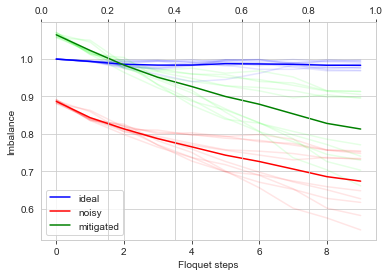

In [22]:
## Plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

for disorder_realization in range(num_disorders):
    ax1.plot(imbalance_all_ideal[disorder_realization], color=(0.0, 0.0, 1.0, 0.1))
    ax1.plot(imbalance_all_noisy[disorder_realization], color=(1.0, 0.0, 0.0, 0.1))
    ax1.plot(imbalance_all_mitigated[disorder_realization], color=(0.0, 1.0, 0.0, 0.1))

ax1.plot(imbalance_ideal_average, color='blue', label="ideal")
ax1.plot(imbalance_noisy_average, color='red', label="noisy")
ax1.plot(imbalance_mitigated_average, color='green', label="mitigated")

ax1.set_xlabel('Floquet steps')
ax1.set_ylabel('Imbalance')
ax1.legend()

# xmin,xmax = ax1.get_xlim()
# ax1.set_xlim([0, 9])
# ax2.set_xlim([0, 9])
# ax1.set_ylim([0.4, 1.05])
# ax1.set_xticks(np.arange(0, 10, 2))
# x2 = np.linspace(xmin, xmax, 50)
# ax2.plot(x2, -np.ones(50)) # Create a dummy plot
# ax2.set_xticks(np.arange(0, 10, 2))
# ax2.set_xticklabels(2*np.arange(0, 10, 2))
# ax2.set_xlabel(r"2q gate depth")
# # ax1.grid(None)
# ax2.grid(None)

plt.style.use({'figure.facecolor':'white'})
plt.show()

## Extrapolation

In [21]:
## Now we need to average over many disorders
num_disorders = 30

# For each disorder realization, make a new disorder
# and compute the charge imbalance using the same physics parameters as before
imbalance_all_ideal = []
imbalance_all_noisy = []
imbalance_all_mitigated = []

for disorder_realization in tqdm(range(num_disorders)):
    disorders = generate_disorder(num_spins, W)
    # print(disorders)

    qc_list = []
    for steps in range(max_steps + 10):
        qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

    transpiled_qc_list = transpile(qc_list, backend_noisy, optimization_level=3)
    job_ideal = execute(qc_list, **run_config_ideal)
    job_noisy = execute(transpiled_qc_list, **run_config_noisy)

    exp_Z_ideal = []
    exp_Z_noisy = []
    exp_Z_mitigated = []


    for i in range(len(qc_list)):
        counts_ideal = job_ideal.result().get_counts()[i]
        counts_noisy = job_noisy.result().get_counts()[i]

        ideal_exp_val = cal_z_exp(counts_ideal)
        noisy_exp_val = cal_z_exp(counts_noisy)

        exp_Z_ideal.append(list(ideal_exp_val)) # Single-Z expectation value of each qubit
        exp_Z_noisy.append(list(noisy_exp_val)) # Single-Z expectation value of each qubit

        graph_data = circuit_to_graph_data_json(
            circuit=transpiled_qc_list[i],
            properties=properties,
            use_qubit_features=True,
            use_gate_features=True,
        )

        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=ideal_exp_val.tolist(),
            noisy_exp_values=[
                noisy_exp_val.tolist()
            ],
            circuit_depth=transpiled_qc_list[i].depth()
        ).to_pyg_data()

        mitigated_exp_val = model(entry.noisy_0,
                            entry.observable,
                            entry.circuit_depth,
                            entry.x,
                            entry.edge_index,
                            entry.batch).tolist()[0]

        exp_Z_mitigated.append(mitigated_exp_val)

    imbalance_ideal = calc_imbalance(exp_Z_ideal, even_qubits, odd_qubits)
    imbalance_noisy = calc_imbalance(exp_Z_noisy, even_qubits, odd_qubits)
    imbalance_mitigated = calc_imbalance(exp_Z_mitigated, even_qubits, odd_qubits)

    imbalance_all_ideal.append(imbalance_ideal)
    imbalance_all_noisy.append(imbalance_noisy)
    imbalance_all_mitigated.append(imbalance_mitigated)

# Average imbalance
imbalance_ideal_average = np.mean(imbalance_all_ideal, axis=0)
imbalance_noisy_average = np.mean(imbalance_all_noisy, axis=0)
imbalance_mitigated_average = np.mean(imbalance_all_mitigated, axis=0)

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
## Plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

for disorder_realization in range(num_disorders):
    ax1.plot(imbalance_all_ideal[disorder_realization], color=(0.0, 0.0, 1.0, 0.1))
    ax1.plot(imbalance_all_noisy[disorder_realization], color=(1.0, 0.0, 0.0, 0.1))
    ax1.plot(imbalance_all_mitigated[disorder_realization], color=(0.0, 1.0, 0.0, 0.1))

ax1.plot(imbalance_ideal_average, color='blue', label="ideal")
ax1.plot(imbalance_noisy_average, color='red', label="noisy")
ax1.plot(imbalance_mitigated_average, color='green', label="mitigated")

ax1.axvline(x = 10, color = 'gray', label = 'training data availability')

ax1.set_xlabel('Floquet steps')
ax1.set_ylabel('Imbalance')
ax1.legend()

xmin,xmax = ax1.get_xlim()
max_x = max_steps + 10
ax1.set_xlim([0, max_x-1])
ax2.set_xlim([0, max_x-1])
ax1.set_ylim([0.4, 1.03])
ax1.set_xticks(np.arange(0, max_x, 4))
x2 = np.linspace(xmin, xmax, 50)
ax2.plot(x2, -np.ones(50)) # Create a dummy plot
ax2.set_xticks(np.arange(0, max_x, 4))
ax2.set_xticklabels(2*np.arange(0, max_x, 4))
ax2.set_xlabel(r"2q gate depth")
# ax1.grid(None)
ax2.grid(None)

plt.style.use({'figure.facecolor':'white'})
plt.show()